### This file contains audio cleaning scripts and more eda-like snippets for experimentation

TODO: Merge appropriate sections into the data processing pipeline.

In [1]:
# disable warnings to tidy up output
import warnings
warnings.filterwarnings("ignore")

# some basic libraries 
from platform import python_version
#import pandas as pd
#import seaborn as sns
import numpy as np
import os
import random

# plot support
import matplotlib.pyplot as plt
import soundfile as sf
import os
from google.cloud import storage
import glob

# scipy
import scipy

# reading audio datasets
import librosa
import librosa.display

[ 31  73 208 385 549]
[ 0.71981859  1.69505669  4.82975057  8.93968254 12.7477551 ]


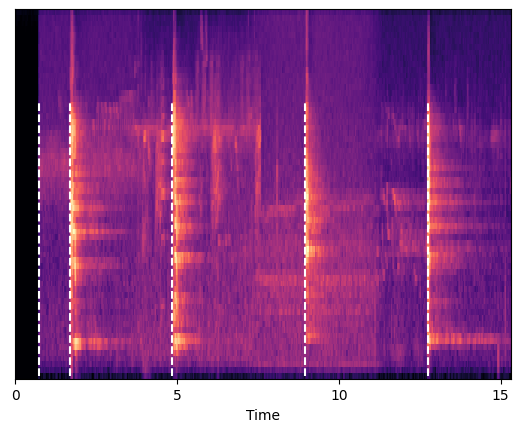

In [10]:
path = r'C:\Users\Tony\Documents\Data\3_Dataset_PE_2\Cervus unicolour Sambar deer\6.wav'

y, sr = librosa.load(path)

#Detect onset frames
onset_frames = librosa.onset.onset_detect(y, sr=sr, backtrack = True, wait=21, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
print(onset_frames)

onset_times = librosa.frames_to_time(onset_frames)
print(onset_times)

onset_samples = librosa.frames_to_samples(onset_frames)

fig = plt.figure()
ax = fig.add_subplot(111)

S = librosa.stft(y)
logS = librosa.amplitude_to_db(abs(S))

#Plot a spectrogram to see what the audio sounds look like
S1 = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, ax = ax,  x_axis='time')

# Plot where the onsets occur to check accuracy
ax.vlines(onset_times, 0, S.max() , linestyle='dashed', color = 'white')
ax.label_outer()

In [4]:
# location of files stored locally
local_path = r'C:\Users\Tony\Documents\Data\3_Dataset_PE_2'
dest_path = r'C:\Users\Tony\Documents\Data\3_Dataset_PE_3' 

# Iterate through local folder

for local_folder in glob.glob(local_path + '/**'):
    folder_name =  os.path.basename(local_folder)
    for local_file in glob.glob(local_folder + '/**'):
        file_name = os.path.basename(local_file).split('.')[0]
        ext = os.path.basename(local_file).split('.')[1]
        y, sr = librosa.load(local_file)
        
        # Find onset starting samples
        onset_frames = librosa.onset.onset_detect(y, sr=sr, backtrack = True, wait=430, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
        onset_samples = librosa.frames_to_samples(onset_frames)
            
        for i in range(min(len(onset_samples), 20)):
            # start the clip 5 seconds before the onset detection
            start = max(onset_samples[i] - (22050*5), 0)
            end = start + (22050*10)
            path = os.path.join(dest_path, folder_name, file_name+"-"+str(i)+ "."+ ext)
            #if shorter than 10 seconds just write the file as is
            if len(y) < 10*22050:
                sf.write(path, y, 22050)
            else:
                # if onset detected after 10 seconds, limit file to 10 seconds
                if end > start + (22050*10):
                    segment = y[start: start + (22050*10)]
                else:
                    segment = y[start: end]
                sf.write(path, segment, 22050)
            
                


In [72]:
y, sr = librosa.load(r'C:\Users\Tony\Documents\Data\3_Dataset_PE_2\Aegotheles cristatus owlet-nightjar\00001.wav')
        
            
onset_frames = librosa.onset.onset_detect(y, sr=sr, backtrack = True, wait=430, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
onset_samples = librosa.frames_to_samples(onset_frames)
print(onset_samples)
start = max(onset_samples[0] - (22050*5), 0)
end = (22050*100)
print(start, end)
segment = y[start: end]
sf.write(r'C:\Users\Tony\Documents\Data\3_Dataset_PE_2\Aegotheles cristatus owlet-nightjar\00001-0.wav', segment, 22050)

[16384]
0 2205000


In [12]:
# Nuke the files (if there are too many samples)
target_dir = r'C:\Users\Tony\Documents\Data\3_Dataset_PE_3\Strepera graculina Pied currawong'
import random
dir=os.listdir(target_dir)
for file in random.sample(dir, int(len(dir)*0.75)): # enter percentage of files to be nuked 
    os.remove(os.path.join(target_dir, file))



28.508214652423884
220500


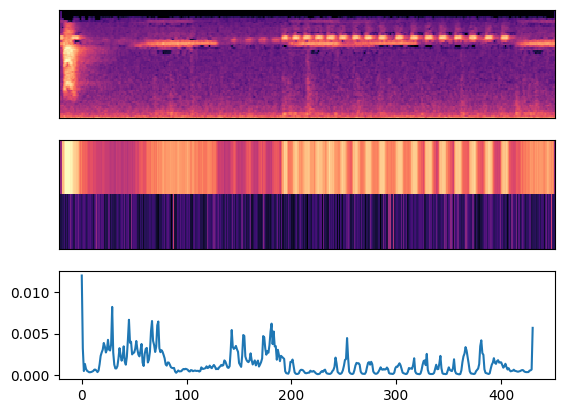

In [61]:
# Additional experimentation with spectral contrast for next stage noise detection.

path = r'C:\Users\Tony\Documents\Data\3_Dataset_PE_3\Aegotheles cristatus owlet-nightjar\00019-3.wav'
y, sr = librosa.load(path)
flatness = librosa.feature.spectral_flatness(y=y)
S1 = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
D1 = librosa.power_to_db(S1, ref=np.max)

S = np.abs(librosa.stft(y))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr, n_bands=1)


fig, ax = plt.subplots(nrows=3)
librosa.display.specshow(D1, ax = ax[0])
librosa.display.specshow(contrast, ax = ax[1])

ax[2].plot(flatness[0])

print(np.mean(contrast))
print(len(y))


So we can see 

In [44]:
# Find audio files with the least spectral contrast

local_folder = r'C:\Users\Tony\Documents\Data\3_Dataset_PE_3\Aegotheles cristatus owlet-nightjar'
dict1 = {}

for local_file in glob.glob(local_folder + '/**'):
    file_name = os.path.basename(local_file).split('.')[0]
    ext = os.path.basename(local_file).split('.')[1]
    y, sr = librosa.load(local_file)
    S = np.abs(librosa.stft(y))
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr, n_bands=1)
    dict1.update({file_name: np.mean(contrast)})
 
